# Train teacher model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import glob
import shutil
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPool2D, BatchNormalization, Input, Conv2DTranspose, Concatenate
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from sklearn.model_selection import train_test_split
import random
import h5py
from IPython.display import display
from PIL import Image as im
import datetime
import random
from tensorflow.keras import layers

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8157556633508212051
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 23378001920
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11288932731596198480
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:4a:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


2022-08-02 12:01:46.081259: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-02 12:01:46.121443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 12:01:46.745117: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 12:01:46.746525: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

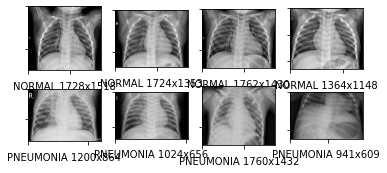

In [3]:
train_path = "./Lecture03-files/chest_xray/train"
for i, folder in enumerate(os.listdir(train_path)):
    if not os.path.isdir(train_path+"/"+folder):
        continue
    for j, img in enumerate(os.listdir(train_path+"/"+folder)):
        filename = train_path+"/"+folder + "/" + img
        img= im.open(filename)
        ax = plt.subplot(3,4,4*i+j+1)
        ax.set_xlabel(folder+ ' '+ str(img.size[0]) +'x'+ str(img.size[1]))
        plt.imshow(img, 'gray')
        ax.set_xlabel(folder+ ' '+ str(img.size[0]) +'x'+ str(img.size[1]))
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        #plt.axis('off')
        img.close()
        if j>2:
            break

In [4]:
import time
def trainGenerator(batch_size, train_path):
    datagen = ImageDataGenerator(rescale=1. / 255, rotation_range=5, shear_range=0.02, zoom_range=0.1,
                                       brightness_range=[0.7,1.3],  horizontal_flip=True,
                                         vertical_flip=True, fill_mode='nearest')
    train_gen = datagen.flow_from_directory(train_path, batch_size=batch_size,target_size=(224, 224), shuffle=True, seed=1, class_mode="categorical" )
    for image, label in train_gen:
        yield (image, label)
def validGenerator(batch_size, valid_path):
    datagen = ImageDataGenerator(rescale=1. / 255, )
    valid_gen = datagen.flow_from_directory(valid_path, batch_size=batch_size, target_size=(224, 224),shuffle=True, seed=1 )
    for image, label in valid_gen:
        yield (image, label)

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
                   include_top = False, # Leave out the last fully connected layer
                   weights = 'imagenet')
len(base_model.layers)
for layer in base_model.layers[:8]:
    layer.trainable = False
x = layers.Flatten()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
#x = layers.BatchNormalization()(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
x = layers.Dense(2)(x)   #linear activation to get pre-soft logits
model = tf.keras.models.Model(base_model.input, x)
opti = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001)
model.compile(optimizer = opti, loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics='acc')
model.summary()

2022-08-02 12:04:09.232004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 12:04:09.232743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 12:04:09.233387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 12:04:09.234162: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-02 12:04:09.234818: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
earlystop = EarlyStopping(monitor='val_acc', patience=5, verbose=1)
filepath="./Lecture03-files/chest_xray/teacher_model/weights-{epoch:02d}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_acc', verbose=1, save_freq='epoch', mode='auto')
callbacks = [checkpoint, earlystop]

vgg_hist = model.fit(trainGenerator(16, train_path), validation_data = validGenerator(16, train_path), validation_steps=20,
                    steps_per_epoch = 128, epochs = 10, callbacks=callbacks)

Found 5232 images belonging to 2 classes.
Epoch 1/10
128/128 [==============================] - ETA: 0s - loss: 0.0529 - acc: 0.9800
Epoch 1: saving model to ./Lecture03-files/chest_xray/teacher_model/weights-01.hdf5
128/128 [==============================] - 26s 201ms/step - loss: 0.0529 - acc: 0.9800 - val_loss: 0.1035 - val_acc: 0.9563
Epoch 2/10
128/128 [==============================] - ETA: 0s - loss: 0.0679 - acc: 0.9756
Epoch 2: saving model to ./Lecture03-files/chest_xray/teacher_model/weights-02.hdf5
128/128 [==============================] - 26s 203ms/step - loss: 0.0679 - acc: 0.9756 - val_loss: 0.0443 - val_acc: 0.9844
Epoch 3/10
128/128 [==============================] - ETA: 0s - loss: 0.0476 - acc: 0.9844
Epoch 3: saving model to ./Lecture03-files/chest_xray/teacher_model/weights-03.hdf5
128/128 [==============================] - 26s 201ms/step - loss: 0.0476 - acc: 0.9844 - val_loss: 0.0425 - val_acc: 0.9906
Epoch 4/10
128/128 [==============================] - ETA: 0s

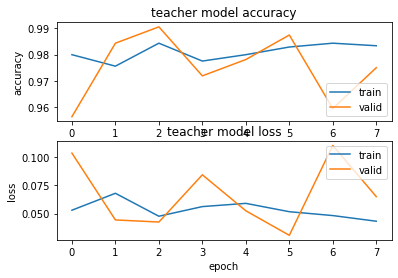

In [10]:
import matplotlib.pyplot as plt 
plt.figure(1)  
# summarize history for accuracy
plt.subplot(211)
plt.plot(vgg_hist.history['acc'])
plt.plot(vgg_hist.history['val_acc'])
plt.title('teacher model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
 # summarize history for loss
plt.subplot(212)
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('teacher model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

Test set shape :  (624, 224, 224, 3)
20/20 [==============================] - 2s 35ms/step


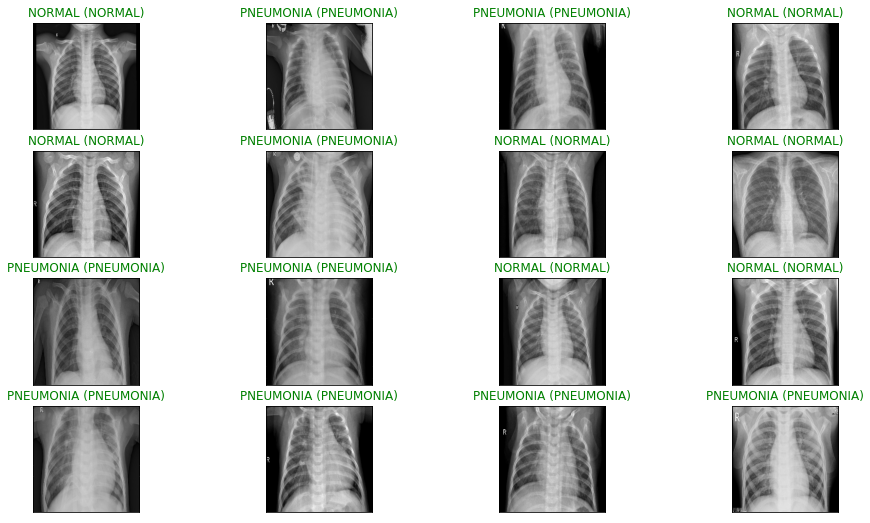

In [11]:
from sklearn.datasets import load_files
import numpy as np
test_dir = './Lecture03-files/chest_xray/test'
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
x_test, y_test,target_labels = load_dataset(test_dir)
from keras.utils import np_utils
y_test = np_utils.to_categorical(y_test,2)
# We just have the file names in the x set. Let's load the images and convert them into array.
# from keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(tf.image.resize(img_to_array(load_img(file)), (224, 224)))
    return images_as_array
x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)
x_test = x_test.astype('float32')/255
# Let's visualize test prediction.
y_pred_logits = model.predict(x_test)
y_pred = tf.nn.softmax(y_pred_logits)
# plot a raandom sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [13]:
model.load_weights("./Lecture03-files/chest_xray/teacher_model/weights-05.hdf5")
print(model.metrics_names) 
loss, acc = model.evaluate(x_test, y_test, verbose = 1)
print('test loss = ', loss) 
print('test accuracy = ',acc)

['loss', 'acc']
20/20 [==============================] - 1s 38ms/step - loss: 0.3468 - acc: 0.9151
test loss =  0.34677350521087646
test accuracy =  0.9150640964508057


# Train student model

In [14]:
# import necessary layers  
from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import AveragePooling2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.backend import square

# https://arxiv.org/pdf/2009.03727.pdf
def act_1(x):
  return 0.563059 + 0.5*x + 0.078047*square(x)
act_fn = act_1

# input
input = Input(shape =(224,224,3))
# 1st Conv Block
x = Conv2D (filters = 2, kernel_size = 4, strides=(2, 2), padding ='valid', activation=None)(input)
x = act_fn(x)
x = Conv2D (filters = 4, kernel_size = 4, strides=(2, 2), padding ='valid', activation=None)(x)
x = act_fn(x)
x = Conv2D (filters = 8, kernel_size = 4, strides=(2, 2), padding ='valid', activation=None)(x)
x = act_fn(x)
x = AveragePooling2D(pool_size = 2, strides = 2, padding ='valid')(x)
x = Flatten()(x)
x = Dense(units = 256, activation =None)(x)
x = act_fn(x)
x = Dropout(0.2)(x)
output = Dense(units = 2)(x)   #last layer with linear activation
# creating the model
s_model_1 = Model (inputs=input, outputs =output)
s_model_1.summary()

class Distiller(Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student
    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.5,
        temperature=2,
    ):
        """ Configure the distiller.
        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature
    def train_step(self, data):
        # Unpack data
        x, y = data
        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        #model = ...  # create the original model
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            # Forward pass of student
            # Forward pass of student
            student_predictions = self.student(x, training=True)
            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )
            loss = self.alpha * student_loss + distillation_loss
        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results
    def test_step(self, data):
        # Unpack the data
        x, y = data
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 2)  98          ['input_2[0][0]']                
                                                                                                  
 tf.math.multiply (TFOpLambda)  (None, 111, 111, 2)  0           ['conv2d[0][0]']                 
                                                                                                  
 tf.math.square (TFOpLambda)    (None, 111, 111, 2)  0           ['conv2d[0][0]']           

In [15]:
model.load_weights("./Lecture03-files/chest_xray/teacher_model/weights-08.hdf5")

# Initialize and compile distiller
distiller = Distiller(student=s_model_1, teacher=model)
distiller.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001),
    metrics=['acc'],
    student_loss_fn=CategoricalCrossentropy(from_logits=True),
distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=0.5,
    temperature=2,
)

earlystop = EarlyStopping(monitor='val_acc', patience=5, verbose=1)
callbacks = [earlystop]
# Distill teacher to student
acc_ = []
val_acc_ = []
for i in range(20):
    distiller_hist = distiller.fit(trainGenerator(16, train_path), validation_data = validGenerator(16, train_path), validation_steps=20,
                 steps_per_epoch = 128, epochs = 1)
    s_model_1.save('./Lecture03-files/chest_xray/student_model/second-order-weights-alpha0.5-temperature2-'+str(i)+'epoch.hdf5', save_format='tf')
    acc_.append(distiller_hist.history['acc'][0])
    val_acc_.append(distiller_hist.history['val_acc'][0])


Found 5232 images belonging to 2 classes.
128/128 [==============================] - 26s 196ms/step - acc: 0.7178 - student_loss: 0.6733 - distillation_loss: 0.4264 - val_acc: 0.7531 - val_student_loss: 0.3780
Found 5232 images belonging to 2 classes.
128/128 [==============================] - 25s 194ms/step - acc: 0.7310 - student_loss: 0.6360 - distillation_loss: 0.4177 - val_acc: 0.7531 - val_student_loss: 0.3775
Found 5232 images belonging to 2 classes.
128/128 [==============================] - 25s 197ms/step - acc: 0.7354 - student_loss: 0.6157 - distillation_loss: 0.4090 - val_acc: 0.7531 - val_student_loss: 0.3813
Found 5232 images belonging to 2 classes.
128/128 [==============================] - 25s 197ms/step - acc: 0.7383 - student_loss: 0.6195 - distillation_loss: 0.4123 - val_acc: 0.7531 - val_student_loss: 0.3839
Found 5232 images belonging to 2 classes.
128/128 [==============================] - 25s 197ms/step - acc: 0.7402 - student_loss: 0.6066 - distillation_loss: 0.

128/128 [==============================] - 25s 198ms/step - acc: 0.8774 - student_loss: 0.2879 - distillation_loss: 0.1707 - val_acc: 0.8781 - val_student_loss: 0.1127
Found 5232 images belonging to 2 classes.
128/128 [==============================] - 25s 199ms/step - acc: 0.8813 - student_loss: 0.2885 - distillation_loss: 0.1681 - val_acc: 0.9125 - val_student_loss: 0.0714
Found 5232 images belonging to 2 classes.
128/128 [==============================] - 25s 198ms/step - acc: 0.8804 - student_loss: 0.2767 - distillation_loss: 0.1628 - val_acc: 0.8906 - val_student_loss: 0.0964
Found 5232 images belonging to 2 classes.
128/128 [==============================] - 25s 200ms/step - acc: 0.8857 - student_loss: 0.2636 - distillation_loss: 0.1566 - val_acc: 0.8906 - val_student_loss: 0.0919
Found 5232 images belonging to 2 classes.
128/128 [==============================] - 25s 197ms/step - acc: 0.8867 - student_loss: 0.2630 - distillation_loss: 0.1515 - val_acc: 0.8750 - val_student_loss:

20/20 [==============================] - 0s 4ms/step - loss: 0.4103 - acc: 0.8397


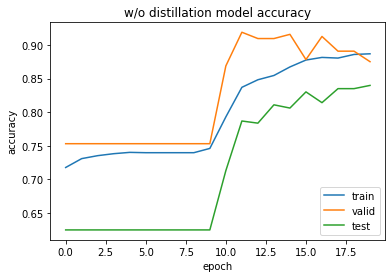

In [16]:
test_acc_ = []
for i in range(20):
    s_model_1.load_weights('./Lecture03-files/chest_xray/student_model/second-order-weights-alpha0.5-temperature2-'+str(i)+'epoch.hdf5')

    opti = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001)
    s_model_1.compile(optimizer = opti, loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics='acc')
    loss, acc = s_model_1.evaluate(x_test, y_test, verbose = 1) 
    test_acc_.append(acc)

import matplotlib.pyplot as plt 
plt.figure(1)  
# summarize history for accuracy
plt.plot(acc_)
plt.plot(val_acc_)
plt.plot(test_acc_)
plt.title('w/o distillation model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid', 'test'], loc='lower right')
plt.show()

In [24]:
s_model_1.load_weights("./Lecture03-files/chest_xray/student_model/second-order-weights-alpha0.5-temperature2-19epoch.hdf5")

opti = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.001)
s_model_1.compile(optimizer = opti, loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics='acc')
loss, acc = s_model_1.evaluate(x_test, y_test, verbose = 1) 
print('test loss = ', loss)
print('test accuracy = ',acc)

20/20 [==============================] - 0s 4ms/step - loss: 0.4103 - acc: 0.8397
test loss =  0.41027358174324036
test accuracy =  0.8397436141967773


In [37]:
s_model_1.load_weights('./Lecture03-files/chest_xray/student_model/second-order-weights-alpha0.5-temperature2-19epoch.hdf5')

def print_weight(data, name):
    shape = data.shape
    dim = ""
    for i in shape:
        dim += "["+str(i)+"]"
    return ("double "+name + dim+"=" +str(data.tolist()).replace("[", "{").replace("]", "}")+";\n")

def dump_weight(data, name, path):
    shape = data.shape
    dim = ""
    for i in shape:
        dim += "["+str(i)+"]"
    f = open(path, "w")
    f.write("double "+name + dim+"=" +str(data.tolist()).replace("[", "{").replace("]", "}")+";\n")
    f.close()

    
import json
import sys
np.set_printoptions(threshold=sys.maxsize)

w = ""
weights_list = s_model_1.get_weights()
CNN1       = weights_list[0]
w += print_weight(CNN1, "CNN1")
print(w)
CNN1_const = weights_list[1]
w += print_weight(CNN1_const, "CNN1_const")
CNN2       = weights_list[2]
w += print_weight(CNN2, "CNN2")
CNN2_const = weights_list[3]
w += print_weight(CNN2_const, "CNN2_const")
CNN3       = weights_list[4]
w += print_weight(CNN3, "CNN3")
CNN3_const = weights_list[5]
w += print_weight(CNN3_const, "CNN3_const")
dense1       = weights_list[6]
w += print_weight(dense1, "dense1")
dense1_const = weights_list[7]
w += print_weight(dense1_const, "dense1_const")
dense2       = weights_list[8]
w += print_weight(dense2, "dense2")
dense2_const = weights_list[9]
w += print_weight(dense2_const, "dense2_const")
f = open("weights.h", "w")
f.write(w)
f.close()

double CNN1[4][4][3][2]={{{{-0.08005031943321228, -0.1604190468788147}, {-0.08727837353944778, -0.1222245916724205}, {-0.1008959487080574, -0.30808213353157043}}, {{0.12722131609916687, 0.07610859721899033}, {0.3059215247631073, -0.2330513447523117}, {0.26184189319610596, 0.20787237584590912}}, {{0.2694287896156311, -0.10334455221891403}, {-0.0720265582203865, 0.17387054860591888}, {-0.15630008280277252, 0.012771573849022388}}, {{-0.07768534123897552, -0.04810646176338196}, {-0.12126573175191879, -0.21109864115715027}, {0.28976181149482727, -0.2187679558992386}}}, {{{0.2181745320558548, -0.06619888544082642}, {0.14610716700553894, -0.09871882200241089}, {-0.18724936246871948, -0.16623517870903015}}, {{-0.11203067749738693, 0.09344465285539627}, {0.2837411165237427, -0.2550061047077179}, {0.21738341450691223, -0.08666928112506866}}, {{0.008134301751852036, 0.1910245269536972}, {-0.1002308800816536, 0.22143258154392242}, {-0.188975527882576, 0.13394832611083984}}, {{0.29719167947769165, 

In [48]:
print(x_test[0].shape)
ss = print_weight(x_test[0], "input_data")
f = open("input_data.h", "w")
f.write(ss)
f.close()

(224, 224, 3)


In [39]:
s_model_1.load_weights('./Lecture03-files/chest_xray/student_model/second-order-weights-alpha0.5-temperature2-19epoch.hdf5')

xt_test = x_test[:10]
ss = print_weight(xt_test, "x_test")
f = open("x_tests.h", "w")
f.write(ss)
f.close()

In [41]:
temp = s_model_1(xt_test)
print(temp)

tf.Tensor(
[[ 1.1771207   0.8821619 ]
 [-1.1905102   5.479478  ]
 [ 1.7271246   1.5143037 ]
 [-1.752258    7.8145742 ]
 [ 1.7798802   5.3784285 ]
 [ 1.247202    1.624041  ]
 [ 0.18980402  1.6924845 ]
 [-0.73335963  3.4914033 ]
 [ 1.1905321   4.3989773 ]
 [ 2.0506961   0.5353639 ]], shape=(10, 2), dtype=float32)


In [42]:
yt_test = y_test[:10]
ss = print_weight(yt_test, "y_test")
f = open("y_tests.h", "w")
f.write(ss)
f.close()

In [43]:
ls

CMakeCache.txt  CMakeLists.txt  Lecture03-files/  weights.h  y_tests.h
CMakeFiles/     distill.ipynb   test.cpp          x_tests.h
